In [289]:
import re
import pandas as pd
from time import time
from collections import defaultdict

import spacy

In [290]:
import re
import nltk
nltk.download('brown')
import itertools
from nltk.corpus import brown

corpus = []

for cat in ['news']:
    for text_id in brown.fileids(cat):
        raw_text = list(itertools.chain.from_iterable(brown.sents(text_id)))
        text = ' '.join(raw_text)
        text = text.lower()
        text.replace('\n', ' ')
        text = re.sub('[^a-z.?! ]+', '', text)
        corpus.append([w for w in text.split() if w != ''])

[nltk_data] Downloading package brown to /home/maxim/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [291]:
txt = []

In [292]:
for line in corpus:
    for word in line:
        txt.append(word)

In [293]:
txt

['the',
 'fulton',
 'county',
 'grand',
 'jury',
 'said',
 'friday',
 'an',
 'investigation',
 'of',
 'atlantas',
 'recent',
 'primary',
 'election',
 'produced',
 'no',
 'evidence',
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.',
 'the',
 'jury',
 'further',
 'said',
 'in',
 'termend',
 'presentments',
 'that',
 'the',
 'city',
 'executive',
 'committee',
 'which',
 'had',
 'overall',
 'charge',
 'of',
 'the',
 'election',
 'deserves',
 'the',
 'praise',
 'and',
 'thanks',
 'of',
 'the',
 'city',
 'of',
 'atlanta',
 'for',
 'the',
 'manner',
 'in',
 'which',
 'the',
 'election',
 'was',
 'conducted',
 '.',
 'the',
 'septemberoctober',
 'term',
 'jury',
 'had',
 'been',
 'charged',
 'by',
 'fulton',
 'superior',
 'court',
 'judge',
 'durwood',
 'pye',
 'to',
 'investigate',
 'reports',
 'of',
 'possible',
 'irregularities',
 'in',
 'the',
 'hardfought',
 'primary',
 'which',
 'was',
 'won',
 'by',
 'mayornominate',
 'ivan',
 'allen',
 'jr.',
 '.',
 'only',
 'a',
 'relative

In [294]:
lines = []

In [295]:
line = ""
for word in txt:
    line = line + word + " "
    if word == '.' or word == '!' or word == '?':
        lines.append(line)
        line = ""

In [296]:
df = pd.DataFrame()
df["spoken_words"] = lines

In [297]:
# df = pd.read_csv('simpsons_dataset.csv')
df.shape

(4205, 1)

In [298]:
df.head()

,spoken_words
0,the fulton county grand jury said friday an in...
1,the jury further said in termend presentments ...
2,the septemberoctober term jury had been charge...
3,only a relative handful of such reports was re...
4,the jury said it did find that many of georgia...


In [299]:
# df.isnull().sum()

In [300]:
# df = df.dropna().reset_index(drop=True)
# df.isnull().sum()

In [301]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [302]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [303]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

In [304]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(3974, 1)

In [305]:
from gensim.models.phrases import Phrases, Phraser

In [306]:
sent = [row.split() for row in df_clean['clean']]

In [307]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [308]:
bigram = Phraser(phrases)

In [309]:
sentences = bigram[sent]

In [310]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

9353

In [311]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 'year',
 'mrs',
 'new',
 'state',
 'president',
 'home',
 'mr',
 'school',
 'man']

In [312]:
import multiprocessing

from gensim.models import Word2Vec

In [313]:
cores = multiprocessing.cpu_count()

In [314]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [315]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [316]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


In [317]:
w2v_model.init_sims(replace=True)

/tmp/ipykernel_6781/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [321]:
w2v_model.wv.most_similar(positive=["woman"])

[('west', 0.9997204542160034),
 ('fine', 0.9997093081474304),
 ('n', 0.9997058510780334),
 ('judge', 0.999700129032135),
 ('child', 0.9996991753578186),
 ('dr', 0.9996987581253052),
 ('f', 0.9996987581253052),
 ('officer', 0.9996985197067261),
 ('road', 0.9996970891952515),
 ('price', 0.9996963739395142)]

In [319]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

KeyError: "Key 'homer_simpson' not present in vocabulary"

In [ ]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.733440101146698),
 ('humiliate', 0.6998323798179626),
 ('snuggle', 0.6951140761375427),
 ('becky', 0.6919245719909668),
 ('rude', 0.6897938251495361),
 ('grownup', 0.6868963241577148),
 ('sorry', 0.6840552091598511),
 ('sweetheart', 0.6824433207511902),
 ('umm', 0.6780276298522949),
 ('ralphie', 0.677593469619751)]

In [ ]:
w2v_model.wv.similarity('maggie', 'baby')

0.7223658

In [ ]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [ ]:
w2v_model.wv.doesnt_match(['homer', 'bart', 'milhouse'])

'homer'

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=1)

[('lisa', 0.6645309925079346)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

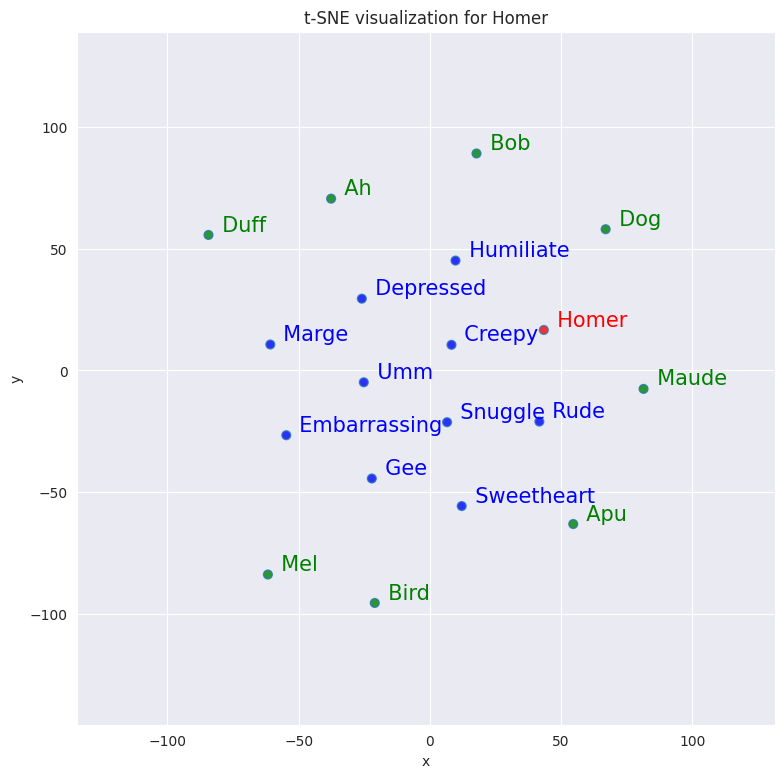

In [ ]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

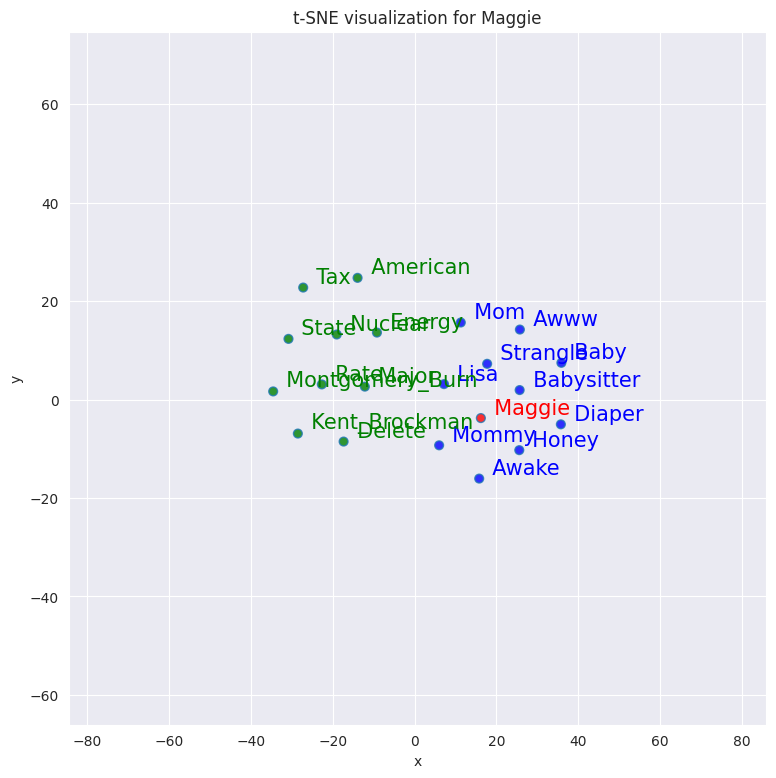

In [ ]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

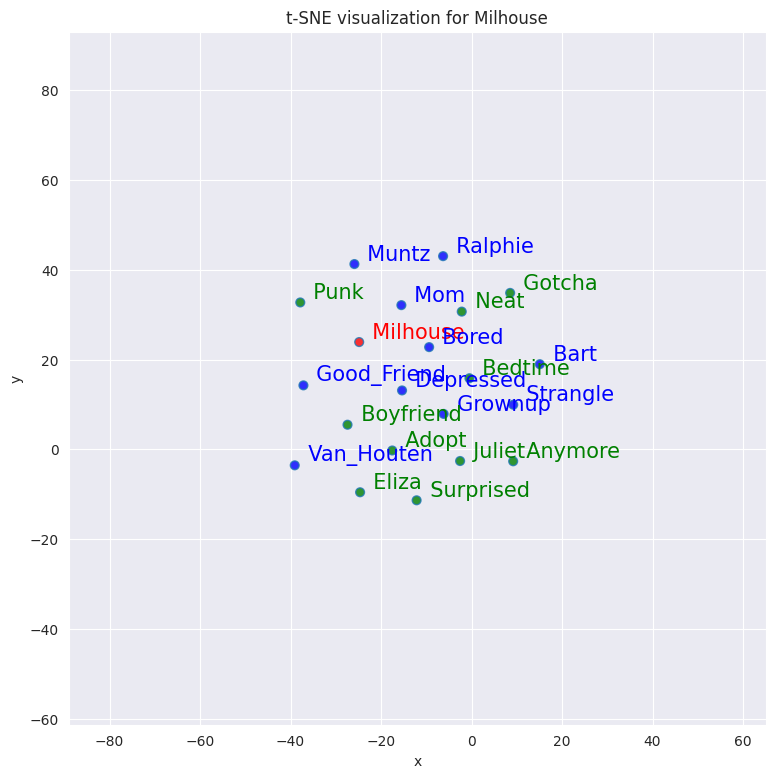

In [ ]:
tsnescatterplot(w2v_model, "milhouse", [t[0] for t in w2v_model.wv.most_similar(positive=["milhouse"], topn=20)][10:])